### Ethereum Price Prediction
dataset = https://www.kaggle.com/datasets/kaushiksuresh147/ethereum-cryptocurrency-historical-dataset\
Also not financial advice, for educational purposes only.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Ethereum Historical Data.csv', index_col=False)
df

,Date,Open,High,Low,Close,Volume
0,2016-03-10,11.20,11.85,11.07,11.75,4
1,2016-03-11,11.75,11.95,11.75,11.95,179
2,2016-03-12,11.95,13.45,11.95,12.92,833
3,2016-03-13,12.92,15.07,12.92,15.07,1295
4,2016-03-14,15.07,15.07,11.40,12.50,92183
...,...,...,...,...,...,...
2376,2022-09-11,1774.38,1786.73,1722.62,1766.93,467415
2377,2022-09-12,1766.99,1782.74,1694.08,1716.42,727783
2378,2022-09-13,1716.45,1751.50,1562.30,1574.47,1304668
2379,2022-09-14,1574.41,1646.09,1556.97,1637.92,858277


I'm going to remove the 'Date' for this project. I would most likely use time series with this dataset, but since this project requests linear regression, I will remove it for simplicity.

In [4]:
df = df.drop('Date',axis=1)

In [5]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

I'm going to add some basic features that has high relevance, based on professional traders... I will find out whether or not it will be useful when predicting or not later.

Feature Engineer: Moving Averages(MA), Relative Strength Index (RSI), MACD 12-26-9, and Momentum

In [6]:
def MA(df): # Moving Average of 7,50,100 days
    df['MA_7days'] = df.iloc[:,3].rolling(window=7).mean()
    df['MA_50days'] = df.iloc[:,3].rolling(window=50).mean()
    df['MA_100days'] = df.iloc[:,3].rolling(window=100).mean()
MA(df)

In [7]:
def EMA(df): # Exponential Moving Average of 7,50,100 days
    df['EMA_7days'] = df['Close'].ewm(span=7,adjust=False).mean()
    df['EMA_50days'] = df['Close'].ewm(span=50,adjust=False).mean()
    df['EMA_100days'] = df['Close'].ewm(span=100,adjust=False).mean()
EMA(df)

In [8]:
def RSIs(df,n):
    df['diff'] = df.Close.diff()
    df['pos'] = df['diff'].clip(lower=0)
    df['neg'] = -1*df['diff'].clip(upper=0)
    ema_pos = df['pos'].ewm(com=(n-1), adjust=False).mean()
    ema_neg = df['neg'].ewm(com=(n-1), adjust=False).mean()
    relative_str = ema_pos / ema_neg
    df['RSI'+str(n)] = 100-(100/(1+relative_str))
RSIs(df, 7)
RSIs(df, 50)
RSIs(df, 100)

In [9]:
def MACD(df): # Moving Average Convergence Divergence... default is 12-26-9
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1-exp2
MACD(df)

In [10]:
def MOM(df,n): #Momentum over 7,50,100 days
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM7'] = MOM(df['Close'], 7)
df['MOM50'] = MOM(df['Close'], 50)
df['MOM100'] = MOM(df['Close'], 100)

In [11]:
df = df.drop(['diff','pos','neg','High','Low', 'Open'],axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        2381 non-null   float64
 1   Volume       2381 non-null   int64  
 2   MA_7days     2375 non-null   float64
 3   MA_50days    2332 non-null   float64
 4   MA_100days   2282 non-null   float64
 5   EMA_7days    2381 non-null   float64
 6   EMA_50days   2381 non-null   float64
 7   EMA_100days  2381 non-null   float64
 8   RSI7         2380 non-null   float64
 9   RSI50        2380 non-null   float64
 10  RSI100       2380 non-null   float64
 11  MACD         2381 non-null   float64
 12  MOM7         2374 non-null   float64
 13  MOM50        2331 non-null   float64
 14  MOM100       2281 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 279.1 KB


In [13]:
df.isnull().sum()

Close            0
Volume           0
MA_7days         6
MA_50days       49
MA_100days      99
EMA_7days        0
EMA_50days       0
EMA_100days      0
RSI7             1
RSI50            1
RSI100           1
MACD             0
MOM7             7
MOM50           50
MOM100         100
dtype: int64

It would be best to drop the NaN values because I can't really "fill" the mising values for the features I implimented from existing features (MA, EMA, Stochs, RSI, etc), otherwise it would introduce unnessary bias.

In [14]:
df = df.dropna()

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,2281.0,8.926117e+02,1.158010e+03,6.700000,160.730000,2.971900e+02,1.283700e+03,4.808380e+03
Volume,2281.0,1.312264e+07,1.030721e+08,0.000000,604785.000000,1.524946e+06,7.903410e+06,1.792561e+09
MA_7days,2281.0,8.904754e+02,1.155773e+03,7.317143,161.225714,2.975571e+02,1.265267e+03,4.690374e+03
MA_50days,2281.0,8.750034e+02,1.141196e+03,8.388200,159.084000,2.859554e+02,1.293179e+03,4.359633e+03
MA_100days,2281.0,8.585676e+02,1.125037e+03,9.447700,163.807000,2.787973e+02,1.036285e+03,4.053609e+03
EMA_7days,2281.0,8.904745e+02,1.154556e+03,7.335611,160.176087,2.976040e+02,1.259483e+03,4.651187e+03
EMA_50days,2281.0,8.752720e+02,1.132915e+03,8.525090,162.756457,2.907541e+02,1.407846e+03,4.230935e+03
EMA_100days,2281.0,8.560201e+02,1.107717e+03,9.502722,171.104730,2.799557e+02,1.172209e+03,3.942851e+03
RSI7,2281.0,5.228939e+01,1.821615e+01,7.113555,39.301222,5.123567e+01,6.524838e+01,9.577951e+01
RSI50,2281.0,5.215214e+01,8.721635e+00,33.347422,46.034447,5.123979e+01,5.700366e+01,8.477758e+01


In [16]:
df.corr()['Close'].sort_values(ascending=False)

Close          1.000000
EMA_7days      0.997692
MA_7days       0.996724
EMA_50days     0.978498
MA_50days      0.969764
EMA_100days    0.957441
MA_100days     0.942937
MOM100         0.270191
MOM50          0.214951
MACD           0.181892
Volume         0.096915
MOM7           0.078423
RSI100         0.071833
RSI50          0.057198
RSI7           0.042698
Name: Close, dtype: float64

<AxesSubplot:title={'center':'Correlation Matrix'}>

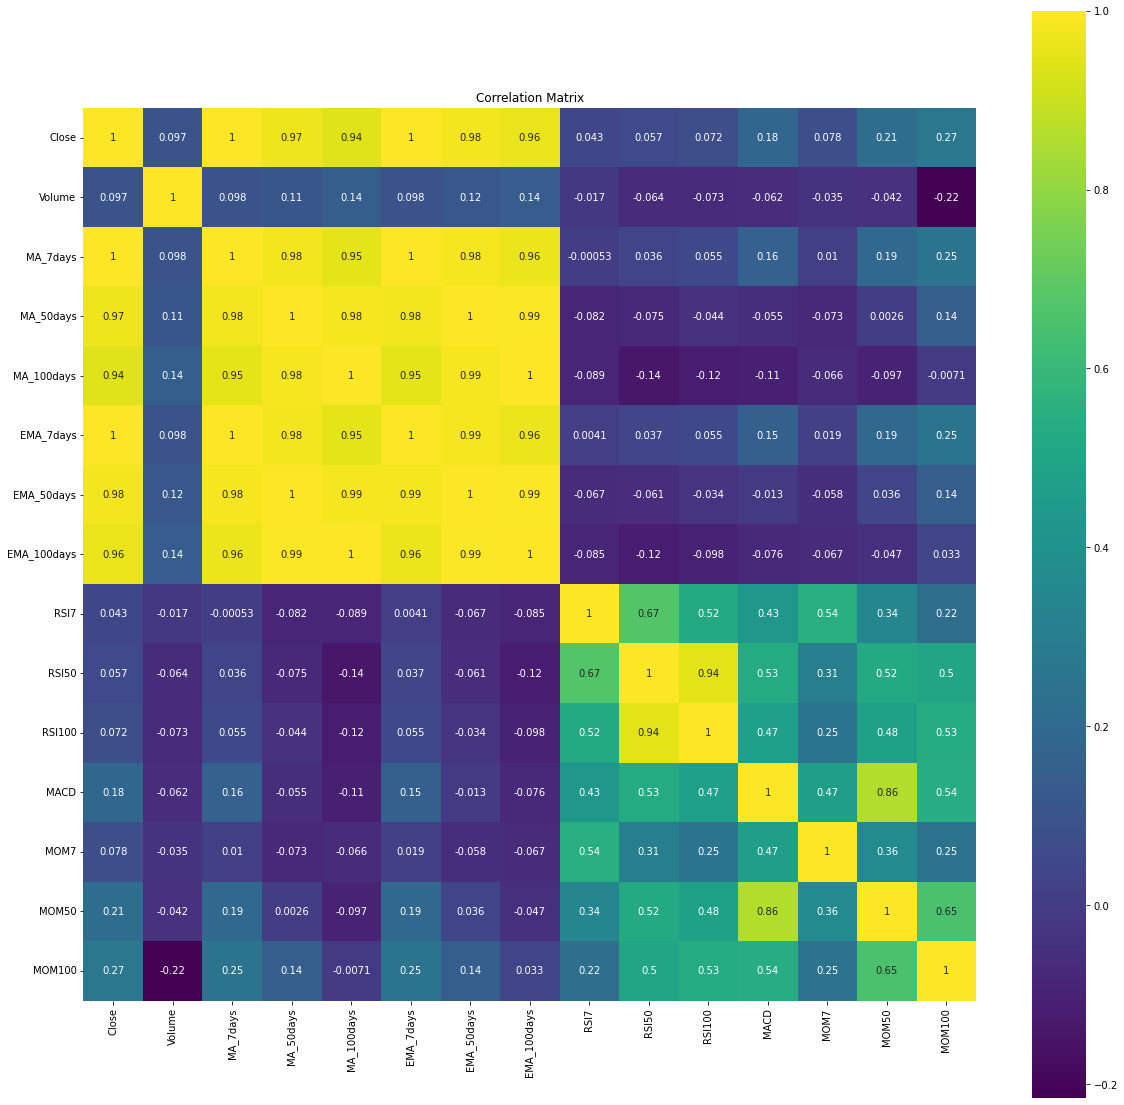

In [17]:
correlation = df.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis')

With the Pearson Coefficient, it seems that the Exponential Moving Average of [7,50,100] days are highly correlated with the close price. The Moving Averages seems to play a good role as well. Momentum and MACD were attributes that traders told me that they used as one of their trading indicators, along with RSI.

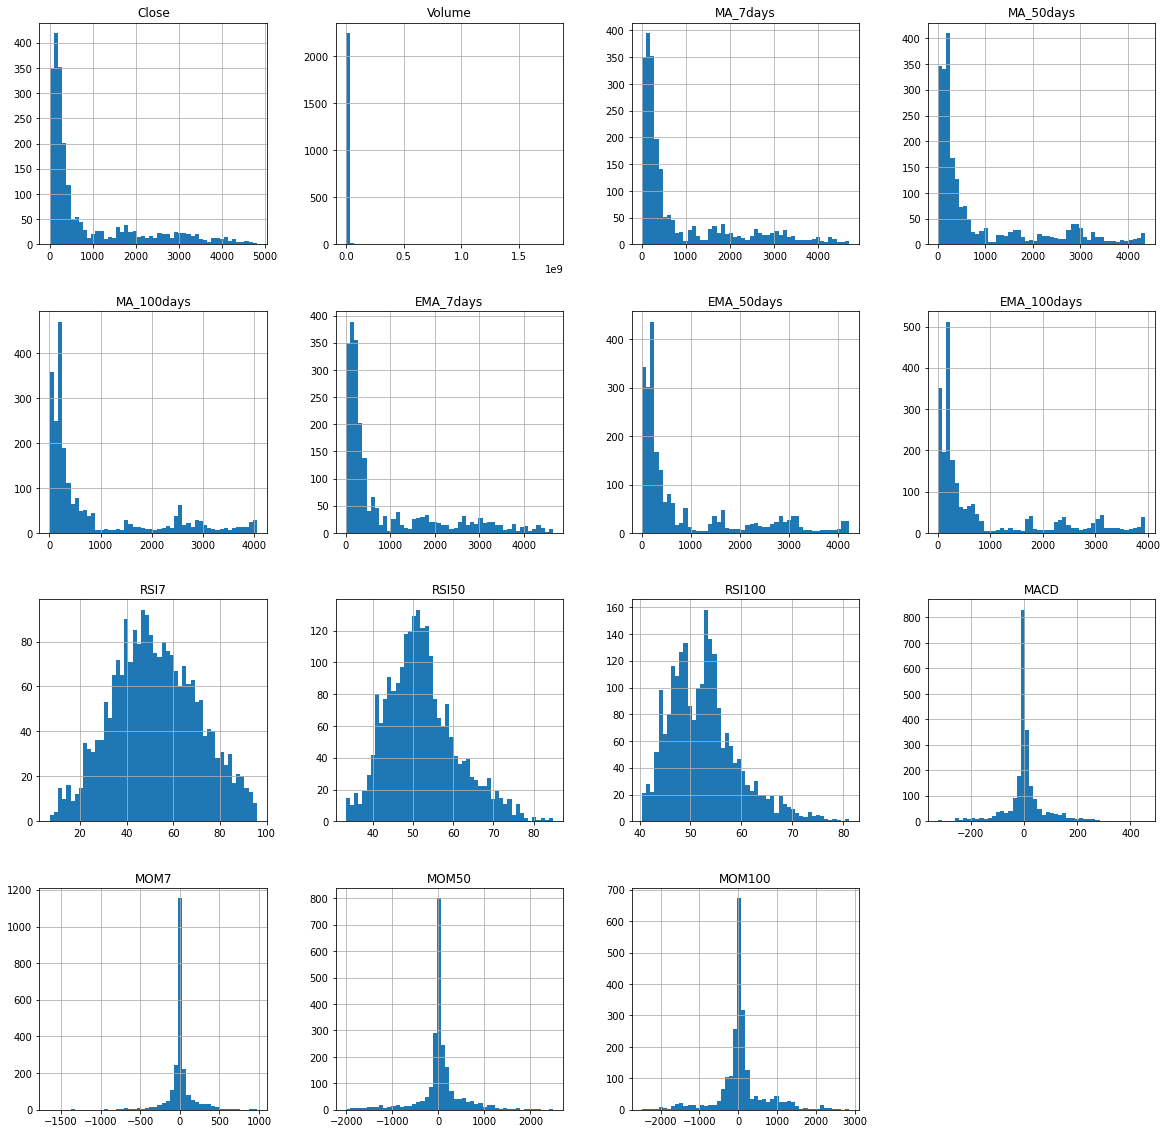

In [18]:
df.hist(bins=50, figsize=(20,20))
plt.show()

The volume data shows the volume transaction per day for Ethereum, where X axis is 1e9, which this current graph can't really support high volumes (Ethereum volume is over a million) given that the bin value is only at 50 to view the other features. I notice that the Moving Averages and Exponential Moving Average [7,50,100] days show a skew right data, where majority of the MA clusters on the left side and have a high variance spread. RSI-7 days follow a normal distribution, and as you increase the amount of days of RSI, the data becomes much more positively skewed, shown above with RSI[7,50,100]. The MACD and Momentum graph shows a tighter normal distribution with a low variance.

<AxesSubplot:xlabel='Close', ylabel='Density'>

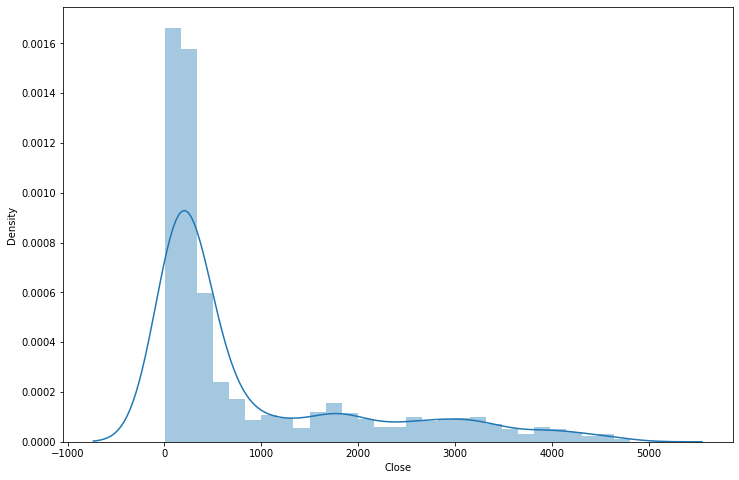

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(df['Close'])

The close price distribution is skewed right as well. It makes sense because there are times where Ethereum stayed under $1000 for the longest time until the momentary surge of Crypto back in 2021.

In [20]:
X = df.drop('Close',axis=1).values
y = df['Close'].values

In [21]:
df.drop('Close',axis=1).columns

Index(['Volume', 'MA_7days', 'MA_50days', 'MA_100days', 'EMA_7days',
       'EMA_50days', 'EMA_100days', 'RSI7', 'RSI50', 'RSI100', 'MACD', 'MOM7',
       'MOM50', 'MOM100'],
      dtype='object')

In [22]:
X

array([[ 3.04181900e+06,  1.69185714e+01,  1.26700000e+01, ...,
        -2.74000000e+00,  3.89000000e+00, -3.40000000e-01],
       [ 1.14396100e+06,  1.64371429e+01,  1.27412000e+01, ...,
        -3.37000000e+00,  3.56000000e+00,  4.80000000e-01],
       [ 1.11153000e+06,  1.56042857e+01,  1.28042000e+01, ...,
        -5.83000000e+00,  3.15000000e+00, -1.02000000e+00],
       ...,
       [ 1.30466800e+06,  1.68791000e+03,  1.67727820e+03, ...,
         1.66200000e+01,  1.35950000e+02, -2.32240000e+02],
       [ 8.58277000e+05,  1.68911143e+03,  1.68102260e+03, ...,
         8.41000000e+00,  1.87220000e+02, -2.22070000e+02],
       [ 1.39195700e+06,  1.68278714e+03,  1.68011400e+03, ...,
        -4.42700000e+01, -4.54300000e+01, -2.23140000e+02]])

Applying PCA:

In [23]:
Xscaled = X

In [24]:
scaler = StandardScaler()
Xscaled = scaler.fit_transform(Xscaled.astype(np.float64))

In [25]:
pca = PCA()
pca.fit_transform(Xscaled)
explained_variance = pca.explained_variance_ratio_

<AxesSubplot:title={'center':'Cumulative Explained Variance by factor'}>

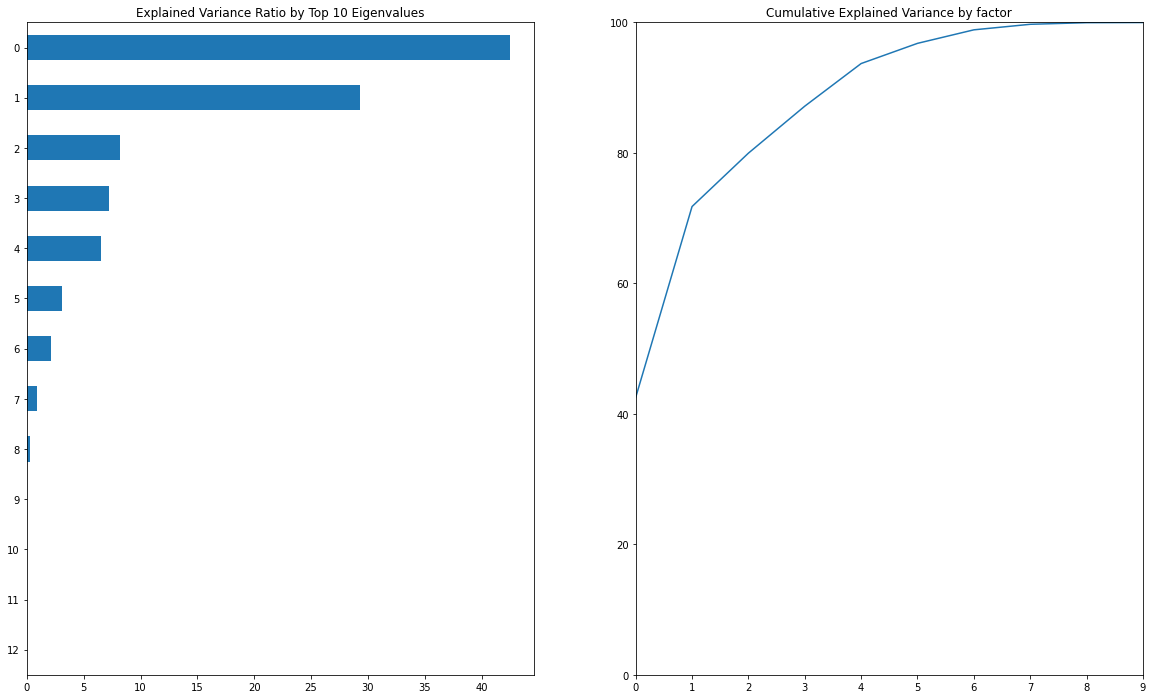

In [26]:
Num_Eigen_val=13
fig, axes = plt.subplots(ncols=2, figsize=(20,12))
Series1 = pd.Series(explained_variance[:Num_Eigen_val]).sort_values()*100
Series2 = pd.Series(explained_variance[:Num_Eigen_val]).cumsum()*100
Series1.plot.barh(ylim=(0,13), label='woohoo', title='Explained Variance Ratio by Top 10 Eigenvalues', ax=axes[0])
Series2.plot(ylim=(0,100), xlim=(0,9), ax=axes[1], title='Cumulative Explained Variance by factor')

In [27]:
pd.Series(np.cumsum(explained_variance)).to_frame('Explained Variance').head(Num_Eigen_val)

,Explained Variance
0,0.425090
1,0.717816
2,0.799672
3,0.871706
4,0.937054
5,0.968006
6,0.988728
7,0.997218
8,0.999696
9,0.999905


In [28]:
df.shape

(2281, 15)

So we can preserve 95% of the variance within 6 Eingenvalues compared to 15. This technique is usually good for reducing training time and dealing with large amount of features.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2281 entries, 100 to 2380
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        2281 non-null   float64
 1   Volume       2281 non-null   int64  
 2   MA_7days     2281 non-null   float64
 3   MA_50days    2281 non-null   float64
 4   MA_100days   2281 non-null   float64
 5   EMA_7days    2281 non-null   float64
 6   EMA_50days   2281 non-null   float64
 7   EMA_100days  2281 non-null   float64
 8   RSI7         2281 non-null   float64
 9   RSI50        2281 non-null   float64
 10  RSI100       2281 non-null   float64
 11  MACD         2281 non-null   float64
 12  MOM7         2281 non-null   float64
 13  MOM50        2281 non-null   float64
 14  MOM100       2281 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 285.1 KB


array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>],
       [<AxesSubplot:title={'center':'Portfolio 2'}>],
       [<AxesSubplot:title={'center':'Portfolio 3'}>],
       [<AxesSubplot:title={'center':'Portfolio 4'}>],
       [<AxesSubplot:title={'center':'Portfolio 5'}>]], dtype=object)

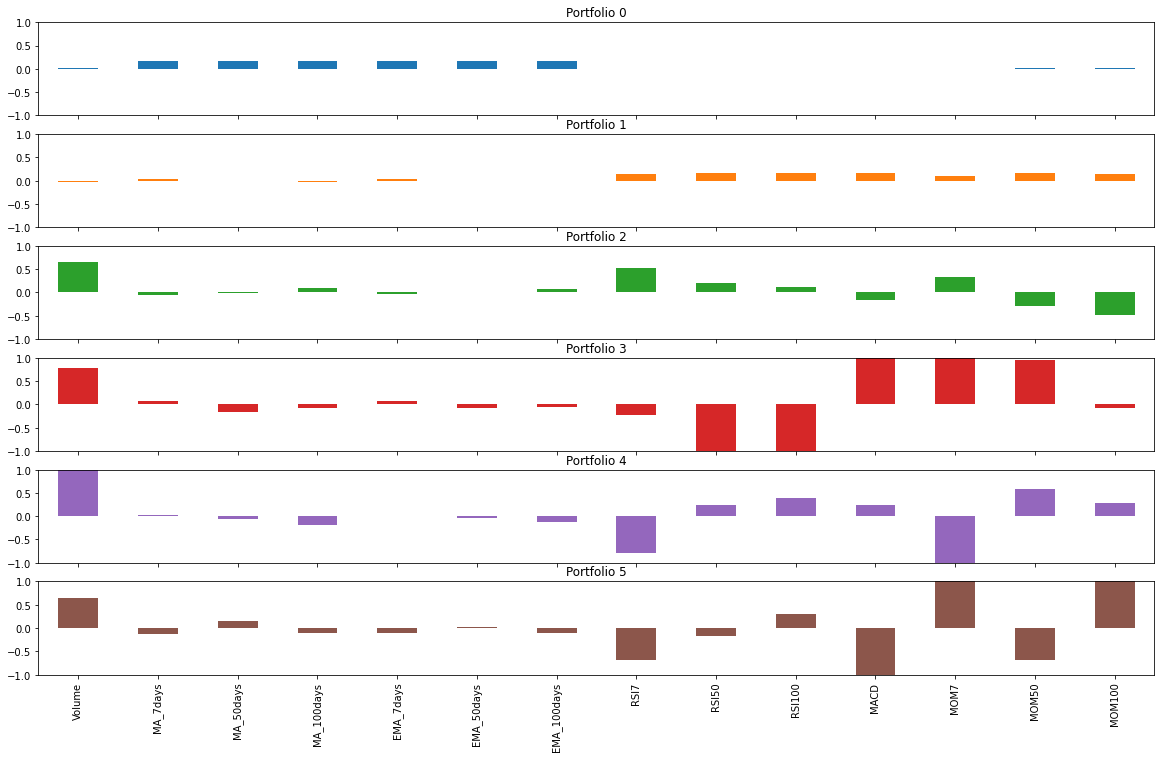

In [30]:
num_comp = 6

top_port = pd.DataFrame(pca.components_[:num_comp], columns=df.drop('Close',axis=1).columns)
eigen_port = top_port.div(top_port.sum(1), axis=0)
eigen_port.index = [f'Portfolio {i}' for i in range(num_comp)]
eigen_port.T.plot.bar(subplots=True, layout=(int(num_comp),1), figsize=(20,12), legend=False, sharey=True, ylim=(-1,1))

So Portfolio 0 explains 42.51% of the variance and explains that the weights are distributed equally.\
Portfolio 1 shows more weights being aplied to RSI, MACD, and momentum, which we saw that the Pearson Coefficient was near the value of 0 while keeping 71% of the variance.\
Portfolio 3 shows inverse correlation RSI vs MACD & Momentum, while also applying more weights to volume.

For the sake of simplicity, I'll exclude PCA from the model, since explaining correlation between features can be tricky in finance; however, there are inferences that can be noted from these explained variances when performing more complex models other than linear regression

### Train Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

### StandardScaler... since we only did scaled version for PCA

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
val_size = 0.2
val = int(df.shape[0]*0.8)
subset = df.iloc[-val:]

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [35]:
models = []
models.append(('LR', LinearRegression(n_jobs=2)))
models.append(('Lasso', Lasso(normalize=True, tol=int(1e-2))))
models.append(('Ridge', Ridge(normalize=True, tol=int(1e-2))))
models.append(('Elastic', ElasticNet()))


In [36]:
num_folds = 10
seed = 43
scoring = 'neg_mean_squared_error'

In [37]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,scoring=scoring)
    cv_results = np.sqrt(-cv_results)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 29.326913 (3.967557)
Lasso: 65.684058 (8.293414)
Ridge: 173.989761 (11.987944)
Elastic: 100.885539 (8.142665)


In [38]:
lr = LinearRegression(n_jobs=2)
lr.fit(X_train, y_train)
lin_pred = lr.predict(X_test)

In [39]:
lin_reg_model = pd.DataFrame({'Actual':y_test.flatten(), 'Predicted': lin_pred.flatten()})

<AxesSubplot:>

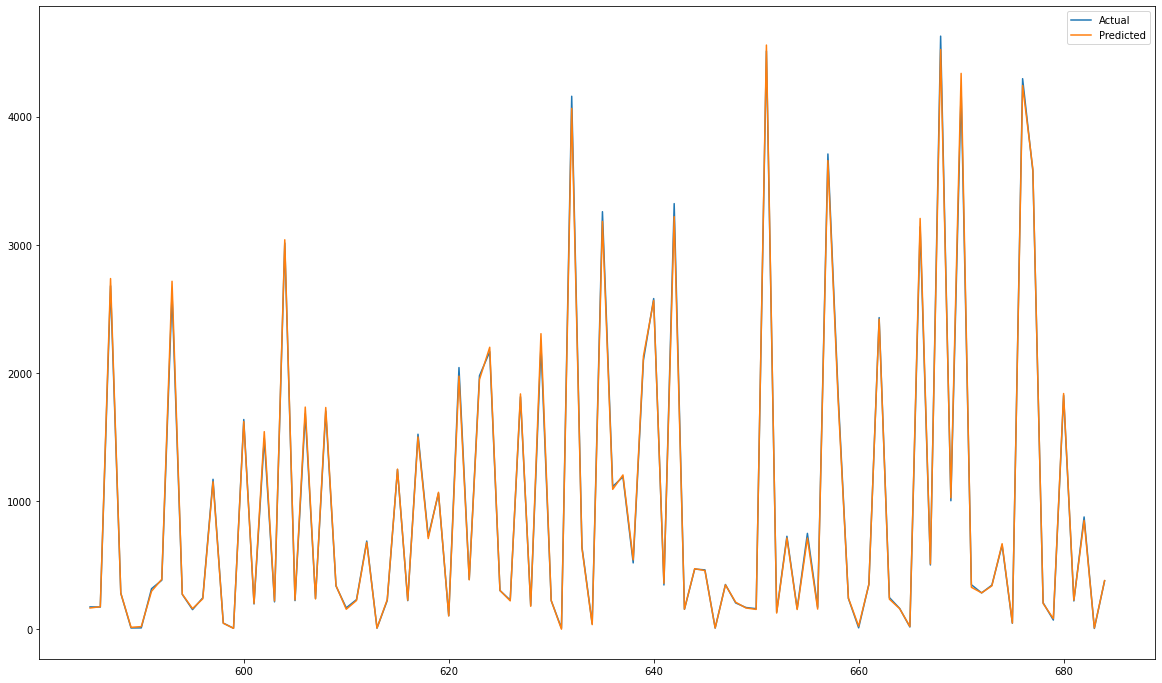

In [40]:
lin_reg_model.tail(100).plot(figsize=(20,12))

In [41]:
import math
MAE_lr= metrics.mean_absolute_error(y_test, lin_pred)
MSE_lr = metrics.mean_squared_error(y_test, lin_pred)
RMSE_lr = math.sqrt(metrics.mean_squared_error(y_test, lin_pred))

In [42]:
lasso = Lasso(normalize=True, tol=int(1e-2))
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [43]:
lasso_model= pd.DataFrame({'Actual':y_test.flatten(), 'Predicted': lasso_pred.flatten()})
lasso_model.head(10)

,Actual,Predicted
0,12.40,43.899591
1,1728.10,1628.139332
2,2891.63,2817.309620
3,2401.10,2258.317465
4,3921.93,3903.324247
5,841.38,852.872247
6,499.87,489.347525
7,211.86,228.594732
8,1940.72,1989.696502
9,235.36,257.896078


In [44]:
MAE_lasso = metrics.mean_absolute_error(y_test, lasso_pred)
MSE_lasso = metrics.mean_squared_error(y_test, lasso_pred)
RMSE_lasso = math.sqrt(metrics.mean_squared_error(y_test, lasso_pred))

In [45]:
ridge = Ridge(normalize=True, tol=int(1e-2))
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

In [46]:
ridge_model= pd.DataFrame({'Actual':y_test.flatten(), 'Predicted': ridge_pred.flatten()})
ridge_model.head(10)

,Actual,Predicted
0,12.40,147.547306
1,1728.10,1588.529967
2,2891.63,2622.320321
3,2401.10,2114.304417
4,3921.93,3513.830514
5,841.38,880.092158
6,499.87,575.296751
7,211.86,295.837720
8,1940.72,1867.844043
9,235.36,322.923991


In [47]:
MAE_ridge = metrics.mean_absolute_error(y_test, ridge_pred)
MSE_ridge = metrics.mean_squared_error(y_test, ridge_pred)
RMSE_ridge = math.sqrt(metrics.mean_squared_error(y_test, ridge_pred))

In [48]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
elastic_pred = elastic_net.predict(X_test)

In [49]:
elastic_model = pd.DataFrame({'Actual':y_test.flatten(), 'Predicted': elastic_pred.flatten()})
elastic_model.head(10)

,Actual,Predicted
0,12.40,88.369196
1,1728.10,1648.188125
2,2891.63,2773.568419
3,2401.10,2216.901238
4,3921.93,3728.800793
5,841.38,878.296130
6,499.87,555.836110
7,211.86,256.548198
8,1940.72,1928.837828
9,235.36,279.355539


In [50]:
MAE_elastic = metrics.mean_absolute_error(y_test, elastic_pred)
MSE_elastic = metrics.mean_squared_error(y_test, elastic_pred)
RMSE_elastic = math.sqrt(metrics.mean_squared_error(y_test, elastic_pred))

In [51]:
eval = {'Models':['Linear Regression','Lasso','Ridge','ElasticNet'],
        'MAE':[MAE_lr,MAE_lasso,MAE_ridge,MAE_elastic],
        'MSE':[MSE_lr,MSE_lasso,MSE_ridge,MSE_elastic],
        'RMSE':[RMSE_lr,RMSE_lasso,RMSE_ridge,RMSE_elastic]}


In [52]:
df1 = pd.DataFrame(eval)

In [53]:
df1 = df1.set_index('Models')
df1

,MAE,MSE,RMSE
Models,,,
Linear Regression,17.190056,996.072000,31.560608
Lasso,47.830059,5459.116713,73.885836
Ridge,140.037297,35028.440285,187.158864
ElasticNet,78.308138,11582.347701,107.621316


In [54]:
df.Close.median()

297.19

We see that Linear Regression outperformed the other models (Lasso, Ridge, ElasticNet) during the evaluation. Lasso didn't perform too terrible compared to Ridge Regression and ElasticNet, where they overfitted terribly. With the median value of $297.19, $31.56 isn't too terrible to confirm the range/estimate it can deviate away from the actual value. A value like $187.1 from Ridge isn't very satisfying to look at if we did the other comparison.

In [55]:
from scipy import stats
confidence = 0.95
squared_errors = (lin_pred-y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([26.79869194, 35.69277392])

Since the Linear Regression performed better than expected, given the complexity of the crypto prediction where it doesn't follow normal distribution, I will avoid using grid search CV. Even though performance will be better on the test set if I modify the hyperparameters, it would unlikely be able to generalize if I have new data introduced.